# R3 pituitary

Appears to be the anterior lobe and marginal zone regions only; no genes seem to be expressed in what would be the proximal lobe region. No detectable DAPI (although we do expect a [fainter DAPI](https://pmc.ncbi.nlm.nih.gov/articles/PMC5755434/)) 

Female mouse #897

In [1]:
region = 'R3'

# Import packages

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
from scipy import sparse

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


# Functions

In [3]:
def plot_knee_curve(adata):
    """
    Plot a single knee curve (UMI counts per barcode) for the entire dataset.
    """
    umi_counts = np.array(adata.X.sum(axis=1)).flatten()
    umi_counts.sort()
    umi_counts = umi_counts[::-1]  # descending

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.loglog(range(1, len(umi_counts) + 1), umi_counts, linewidth=2, color="black")

    ax.set_xlabel("Barcodes", fontsize=14)
    ax.set_ylabel("UMI Counts", fontsize=14)
    ax.axhline(y=500, linewidth=1.5, color="#505050", linestyle='--', label='500 UMI')
    ax.axhline(y=200, linewidth=1.5, color="#A0A0A0", linestyle='--', label='200 UMI')

    ax.legend(fontsize=12)
    ax.grid(True, which="both", linestyle=':', linewidth=0.5)
    ax.set_title("Knee Plot", fontsize=16)
    plt.tight_layout()
    plt.show()


# Load Anndata

In [4]:
adata = sq.read.vizgen(
    path=f"pilot_data/region_{region}/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv",
)

adata.layers["counts"] = adata.X.copy()
adata.obs['region'] = region

In [5]:
sc.pp.calculate_qc_metrics(adata, percent_top=(50, 100, 200, 300), inplace=True)


In [6]:
adata

AnnData object with n_obs × n_vars = 9437 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'
    layers: 'counts'

# QC plots

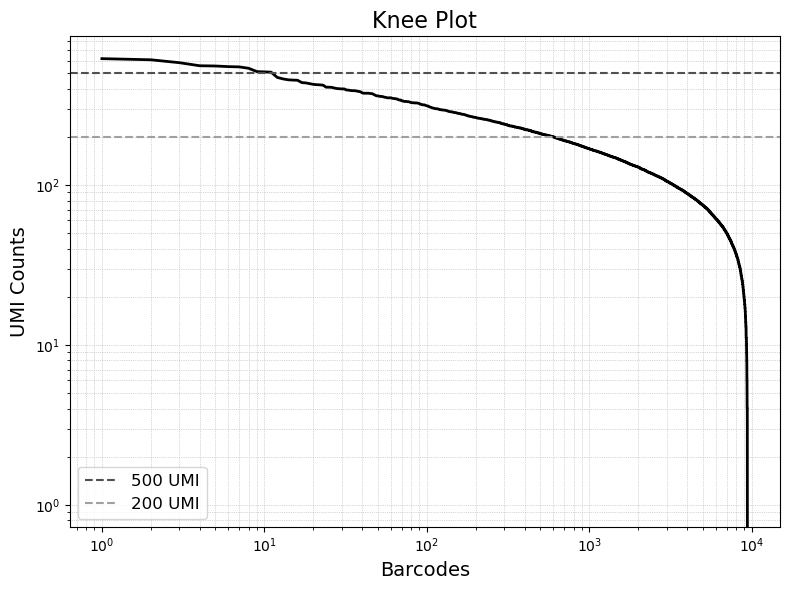

In [7]:
plot_knee_curve(adata)


<Axes: >

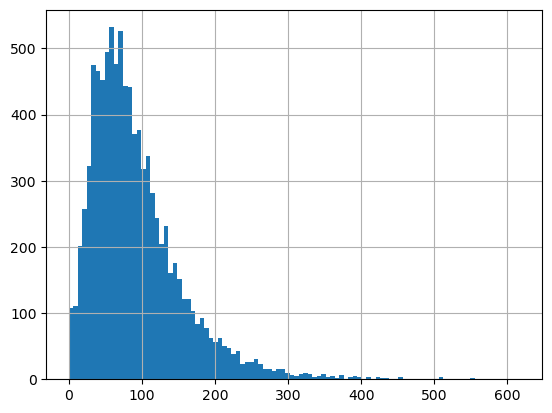

In [8]:
ser_exp = adata.to_df().sum(axis=1)
ser_exp.hist(bins=100)


<Axes: >

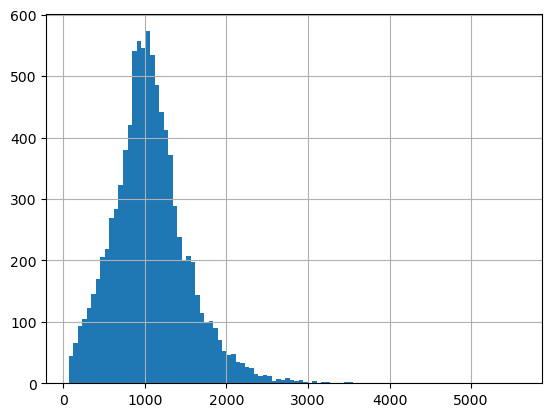

In [9]:
ser_volume = adata.obs['volume']
ser_volume.hist(bins=100)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` par

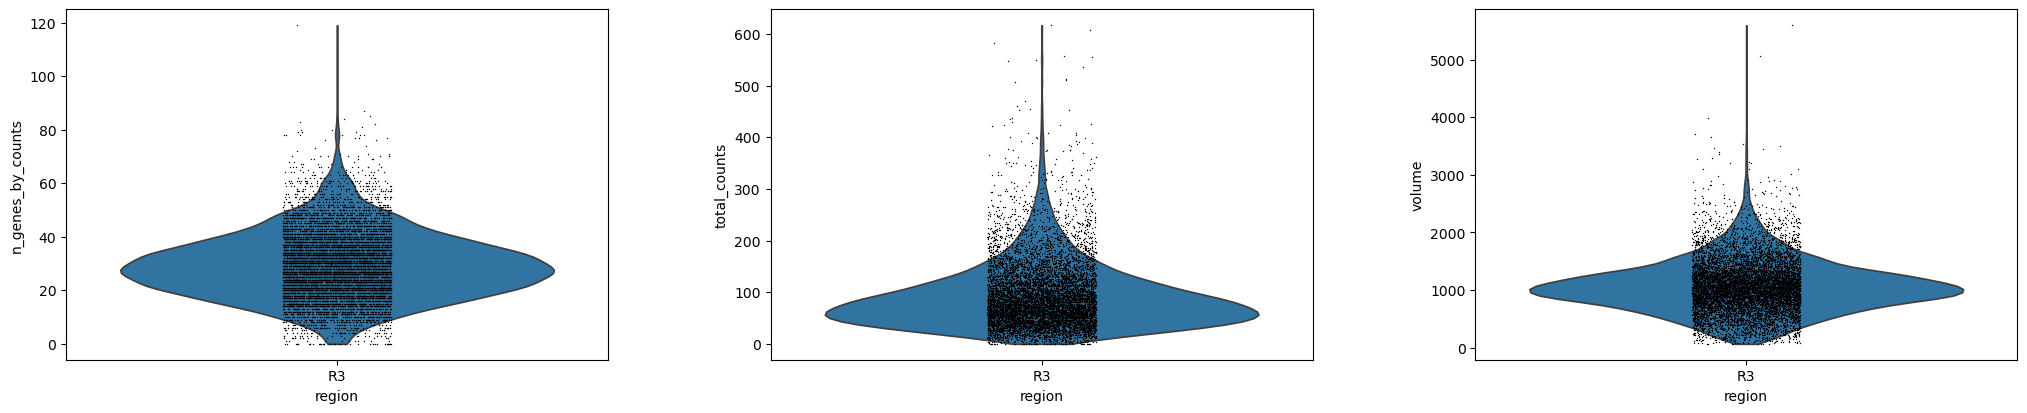

In [10]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "volume"],
    groupby="region",
    multi_panel = True
)

# Filter by volume and counts

Both low and high

In [11]:
vol = adata.obs["volume"]
median_volume = np.median(vol)
volume_filter = (vol >= 100) & (vol <= 3 * median_volume)
adata = adata[volume_filter].copy()

# Remove cells with total RNA in top/bottom 1%
total_counts = adata.obs['total_counts']
lower = np.percentile(total_counts, 1)
upper = np.percentile(total_counts, 99)
in_range = (total_counts >= lower) & (total_counts <= upper)
adata = adata[in_range].copy()


In [12]:
adata.obs['total_counts'].min()


7.0

In [13]:
adata.write_h5ad(f"pilot_data/region_{region}/region_{region}_adata_filt.h5ad")

In [43]:
adata = sc.read_h5ad(f"pilot_data/region_{region}/region_{region}_adata_filt_scrublet.h5ad")
adata.obs['region'] = region
coords = adata.obsm["spatial"].copy()

# Get bounds to orient around image size
max_x, max_y = coords[:, 0].max(), coords[:, 1].max()

# Rotate 90° CCW: (x, y) → (max_y - y, x)
rotated_coords = np.column_stack([
    max_y - coords[:, 1],
    coords[:, 0]
])

adata.obsm["spatial"] = rotated_coords


In [44]:
adata

AnnData object with n_obs × n_vars = 9205 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'region_colors', 'scrublet', 'spatial'
    obsm: 'blank_genes', 'spatial'
    layers: 'counts'

# Correlation of cell volume and counts

# Normalize and filter by doublet score

https://www.nature.com/articles/s41586-023-06808-9

In [45]:
# normalize counts by volume
inv_volumes = 1 / adata.obs["volume"].values # scaling factor 
inv_vol_diag = sparse.diags(inv_volumes)
adata.layers["counts_volume_norm"] = inv_vol_diag @ adata.layers["counts"]

# scale
total_counts = np.array(adata.layers["counts_volume_norm"].sum(axis=1)).flatten()
scale_factor = 250 / np.mean(total_counts)

adata.layers["counts_volume_norm_scaled"] = adata.layers["counts_volume_norm"] * scale_factor

adata = adata[adata.obs["doublet_score"] <= 0.25].copy()


In [46]:
adata

AnnData object with n_obs × n_vars = 9194 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'region_colors', 'scrublet', 'spatial'
    obsm: 'blank_genes', 'spatial'
    layers: 'counts', 'counts_volume_norm', 'counts_volume_norm_scaled'

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` par

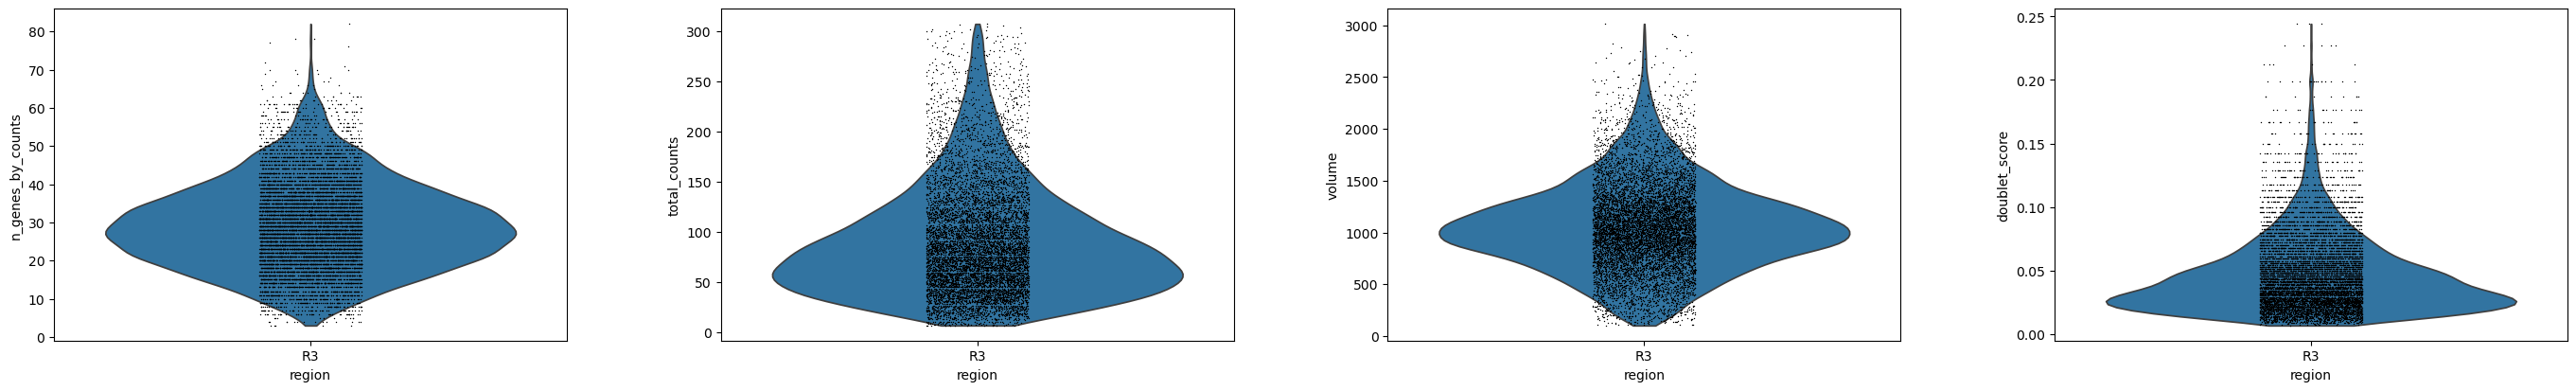

In [47]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "volume", "doublet_score"],
    groupby="region",
    multi_panel = True
)

# Log normalization, PCA, clustering, UMAP

In [48]:
adata.X = adata.layers['counts_volume_norm_scaled'].copy()

In [49]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
# sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution = 2)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


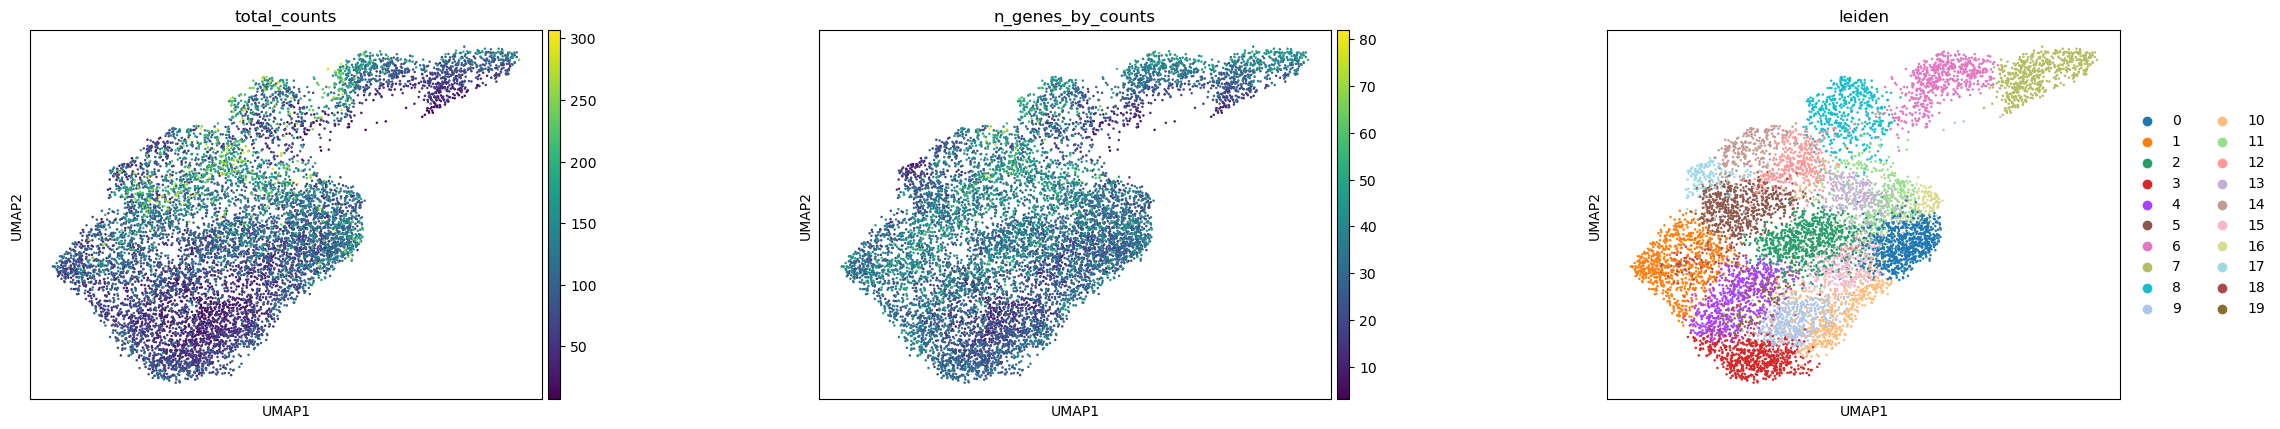

In [50]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

## Marker gene dotplot

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:179: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

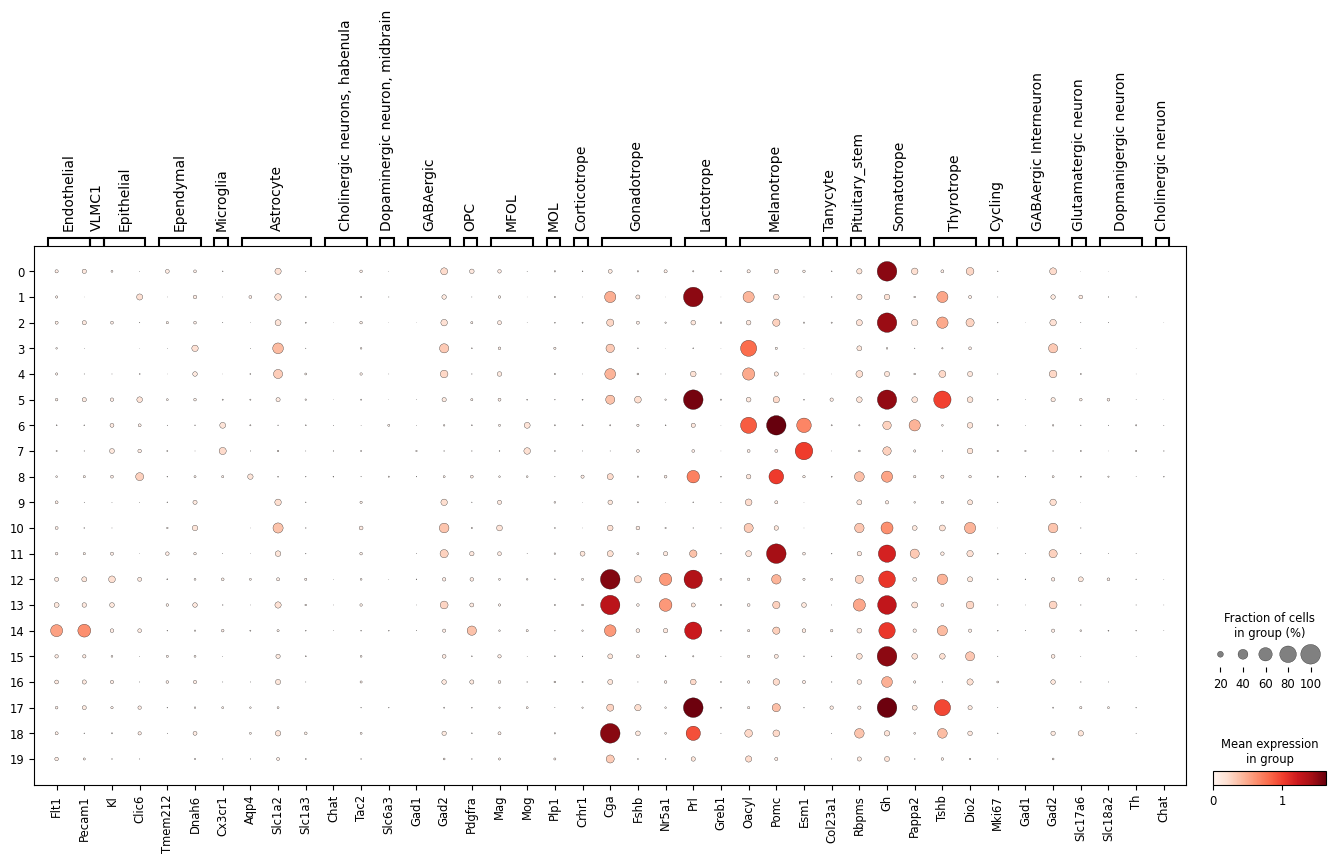

In [51]:
gene_list  = adata.var_names.tolist()
annotation_dict = {
    "Endothelial": ["Flt1","Pecam1"],
    "Pericyte": ["Vtn"],
    "Fibroblast": ["Bnc2","Fbxl7"],
    "VLMC1": ["Dcn"],
    "VLMC2": ['Egfr','Tbx15','Rspo3','Slc26a7'],
    "Epithelial":["Kl","Ttr","Clic6"], # http://mousebrain.org/celltypes/CHOR.html
    "Ependymal":["Tmem212","Dnah6"],
    "Hypendymal":['Spp2','Sspo'], # http://mousebrain.org/celltypes/HYPEN.html
    "Microglia": ["Cx3cr1"],
    "Astrocyte": ["Aqp4","Clu","Cpe","Gfap","Gja1","Slc1a2","Slc1a3"],
    "Excitatory neuron, thalamus": ["Synpo2","Prkcd","Ramp3","Ptpn3","Shox2"], #http://mousebrain.org/celltypes/DEGLU1.html
    "Cholinergic neurons, habenula": ['Chat','Lrrc55','Tac2','Nwd2'],
    "Dopaminergic neuron, midbrain": ["Slc6a3","En1"], # http://mousebrain.org/celltypes/MBDOP2.html
    "GABAergic": ["Gad1","Gad2"],
    "OPC": ["Pdgfra"],
    "COP": ["C1ql1"],
    "MFOL": ["Mag","Mog"],
    "MOL": ["Plp1"],
    "Corticotrope": ["Crhr1","Tbx19"],
    "Gonadotrope": ["Cga","Fshb","Nr5a1"],
    "Lactotrope": ["Prl","Greb1","Agtr1a"],
    "Melanotrope": ["Oacyl","Pomc","Esm1"],
    "Tanycyte": ['Col23a1','Rax','Lhx2','Prdx6','Ptn'],
    "Pituitary_stem": ["Rbpms","Cyp2f2","Sox2","Aldh1a2"],
    "Somatotrope": ["Gh","Pappa2"],
    "Thyrotrope": ["Tshb","Dio2"],
    "Cycling": ["Top2a","Mki67"],
    "GABAergic Interneuron":["Gad1", "Gad2"],
    "Glutamatergic neuron": ["Slc17a6"],
    "Dopmanigergic neuron": ["Slc18a2", "Th"],
    "Cholinergic neruon":["Chat"],
    "Neuron": ["Mir124a-1hg","Snap25"]
}
filtered_markers = {
    key: [v for v in vals if v in gene_list]
    for key, vals in annotation_dict.items()
}
keys_to_remove = ["Pericyte", "Fibroblast", 
                  "VLMC2","Hypendymal",
                  "Excitatory neuron, thalamus","COP","Neuron"]
for k in keys_to_remove:
    filtered_markers.pop(k, None)   # safely remove if present

sc.pl.dotplot(adata, 
              filtered_markers, 
              'leiden', 
              mean_only_expressed = False, 
              log=True, 
             )

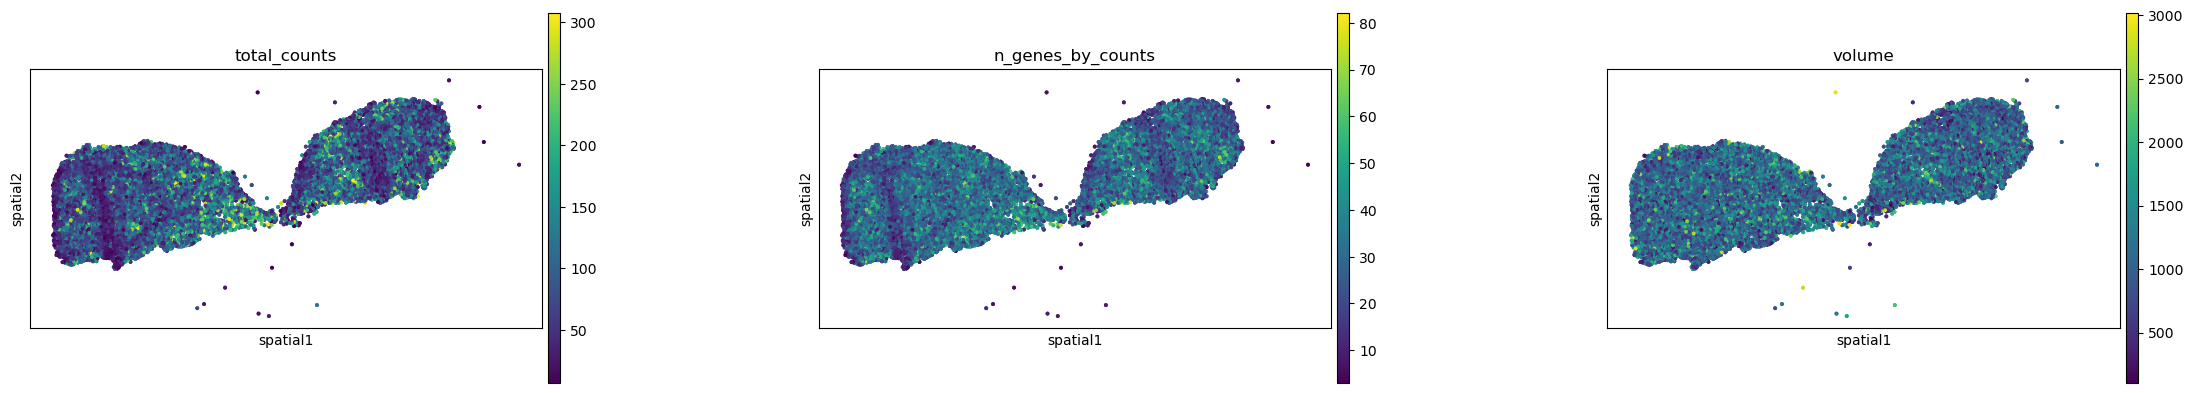

In [52]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "volume",
    ],
    wspace=0.4,
)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


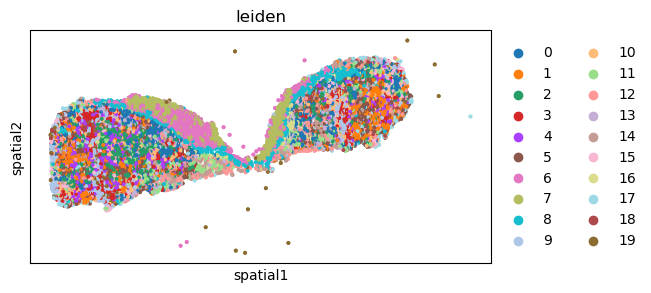

In [53]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

## Highlight each cluster 

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in p

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in p

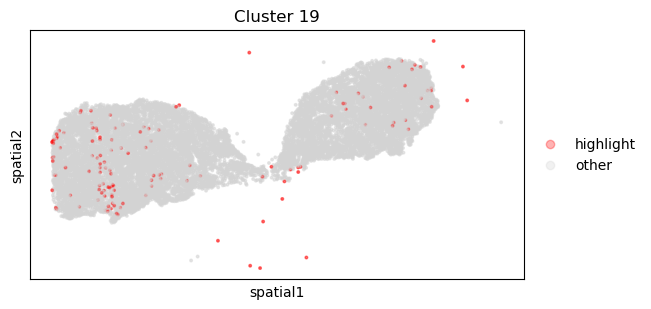

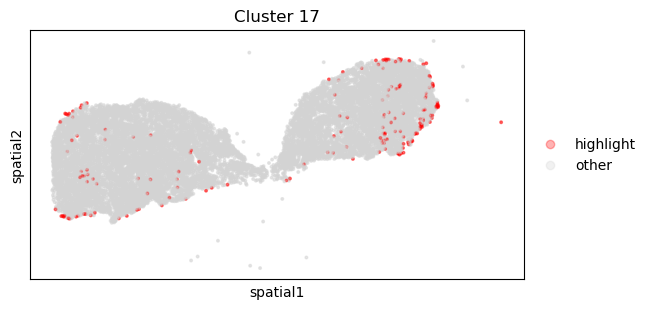

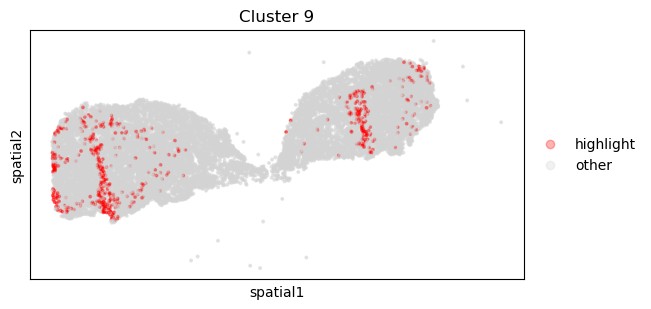

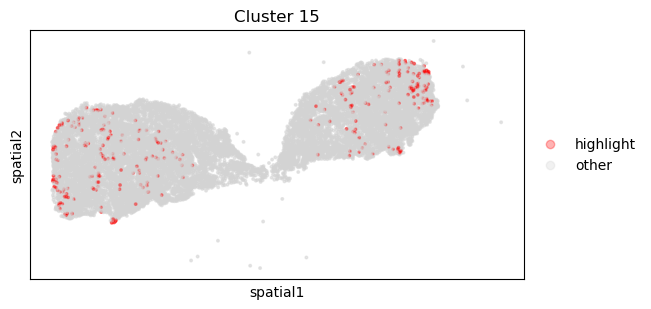

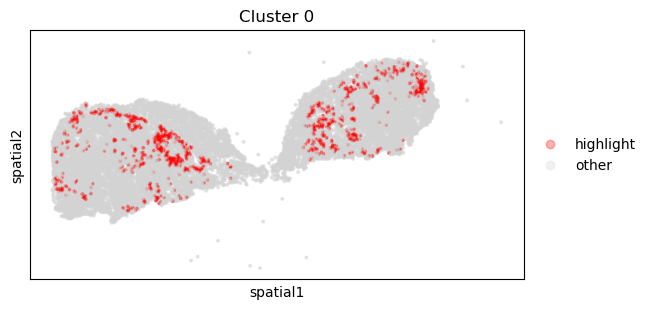

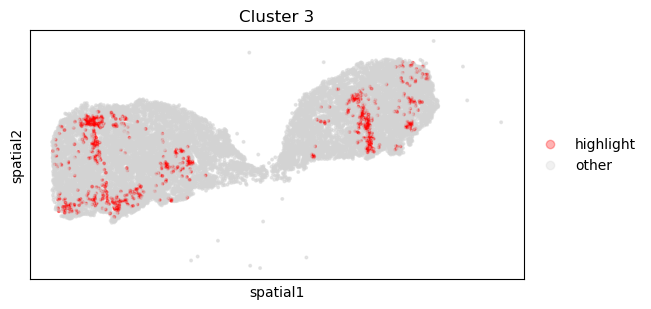

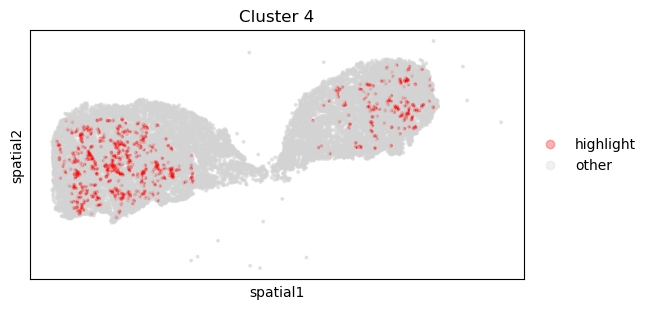

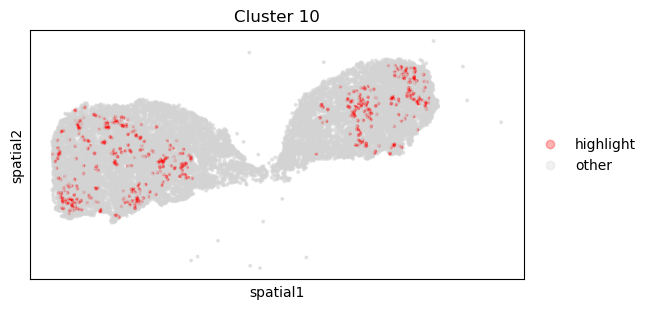

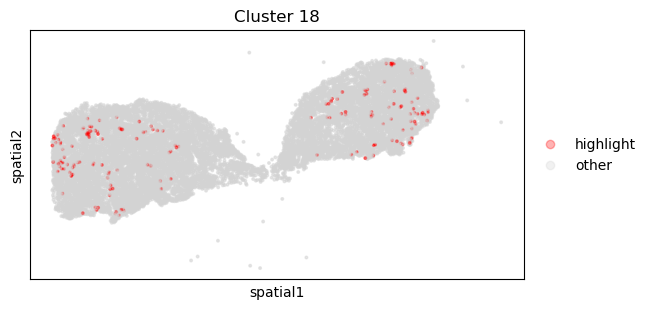

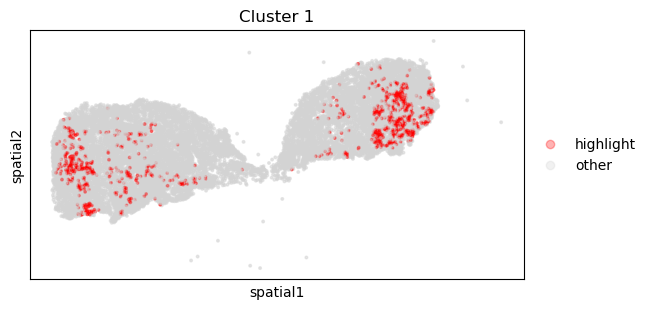

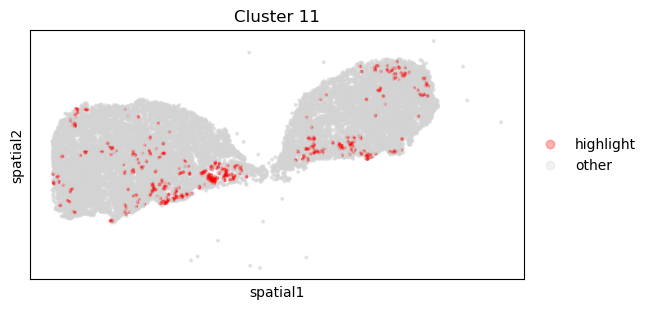

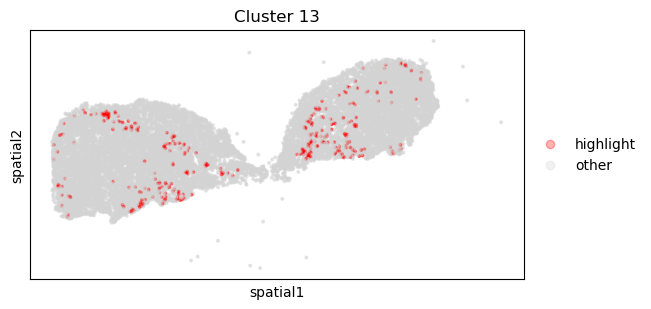

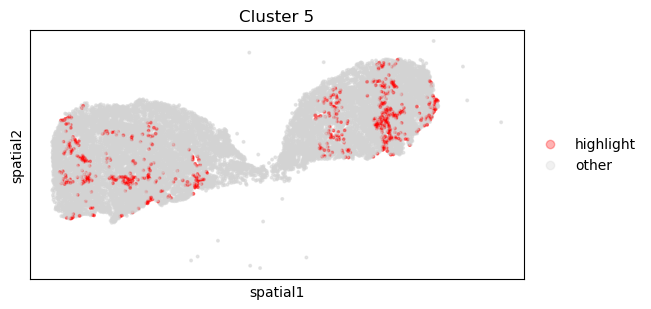

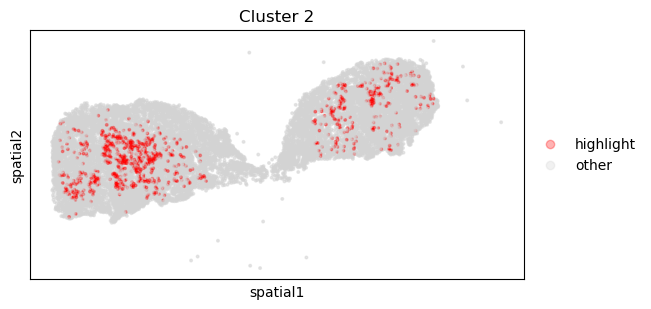

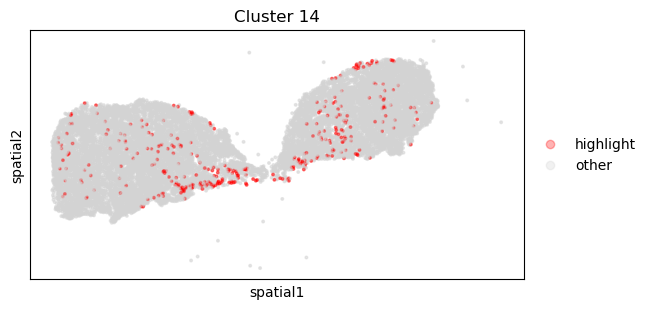

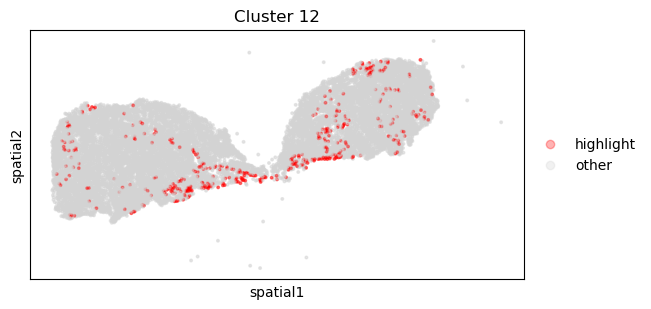

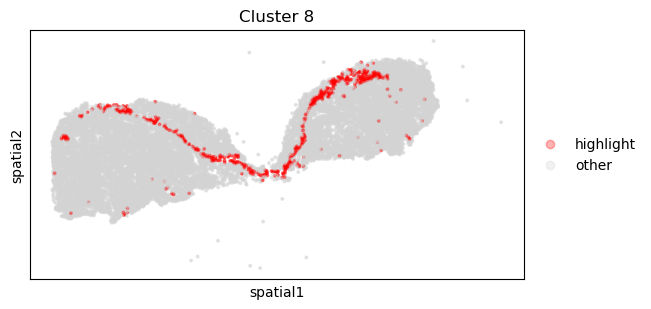

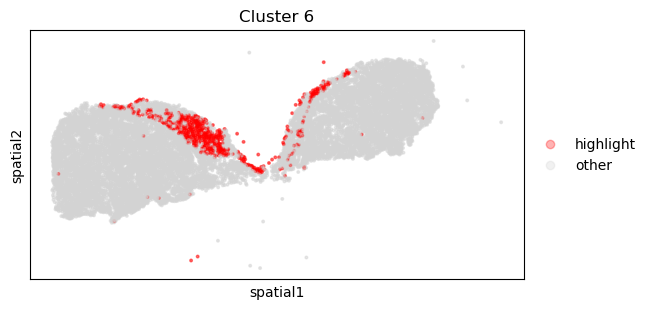

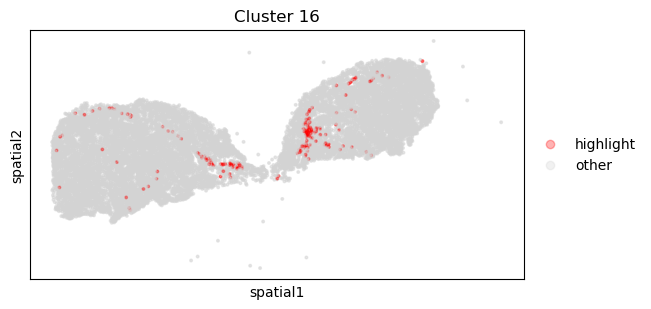

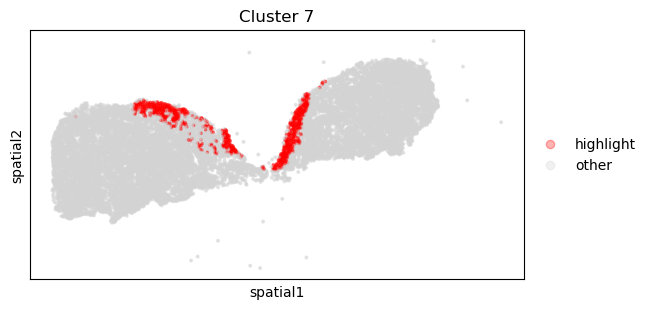

In [54]:
from matplotlib.colors import ListedColormap
import scanpy as sc
import squidpy as sq

# Get all unique leiden clusters
clusters = adata.obs["leiden"].unique().astype(str)

for cluster in clusters:
    adata.obs["highlight"] = adata.obs["leiden"].astype(str).apply(
        lambda x: "highlight" if x == cluster else "other"
    )

    custom_palette = ListedColormap(["red", "lightgrey"])

    sq.pl.spatial_scatter(
        adata,
        shape=None,
        color="highlight",
        palette=custom_palette,
        wspace=0.4,
        alpha=0.3,
        title=f"Cluster {cluster}",
    )


## Calculate markers

In [55]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")


/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pand

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pand

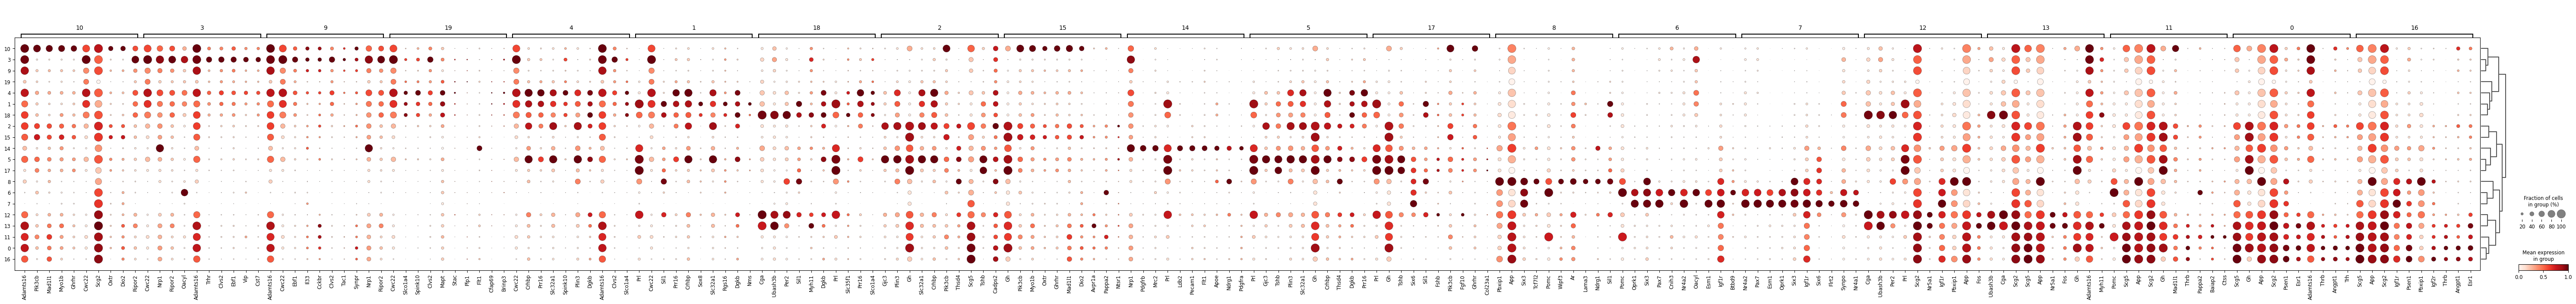

In [56]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=10
)

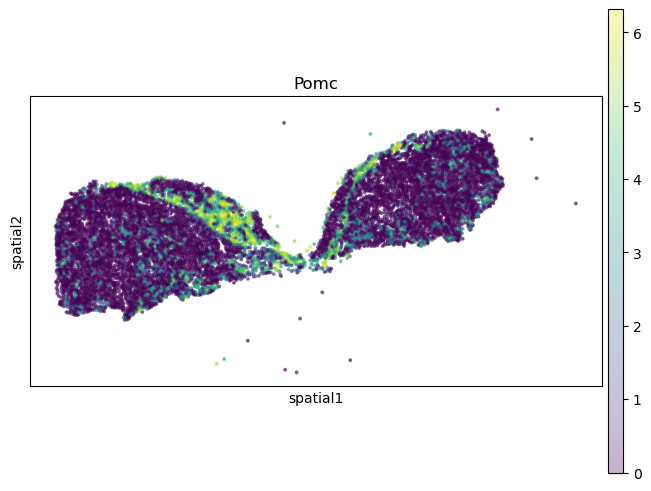

In [57]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color=["Pomc"], # Melanotrope marker
    wspace=0.4,
    alpha=0.3,    
)

/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:843: FutureWarning: 

The `scale` par

[<Axes: ylabel='n_genes_by_counts'>, <Axes: ylabel='total_counts'>]

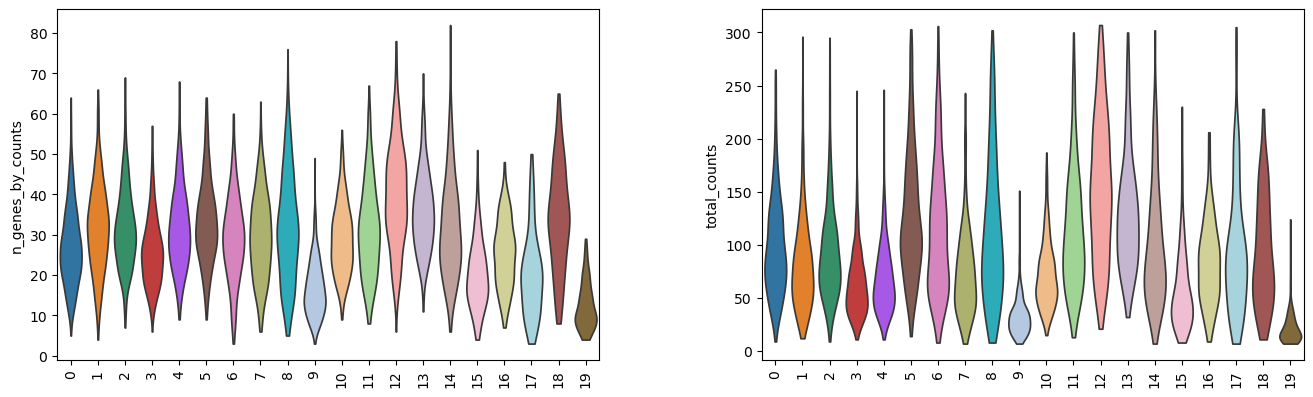

In [58]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    groupby='leiden',
    size=0,
    rotation = 90,
    multi_panel=True,
    show = False
)

## Assign celltypes

In [59]:
leiden_to_celltype = {
    '0':  'somatotroph',  # Gh+, 
    '1':  '', # Prl+
    '2':  '',
    '3':  '',
    '4':  '',
    '5':  '',
    '6':  '',
    '7':  '',
    '8':  '',
    '9':  '',
    '10': '',
    '11': '',
    '12': '',
    '13': '',
    '14': '',
    '15': '',
    '16': '',
    '17': '',
    '18': '',
    '19': '',
}

# Add the annotation to your adata.obs
adata.obs['celltype'] = adata.obs['leiden'].map(leiden_to_celltype).astype('category')


# Calculate spatial neighbors

In [60]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)


In [61]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")


  0%|                                                  | 0/1000 [00:00<?, ?/s]/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 121.57/s]


/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/Users/liz/miniconda3/envs/squid_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


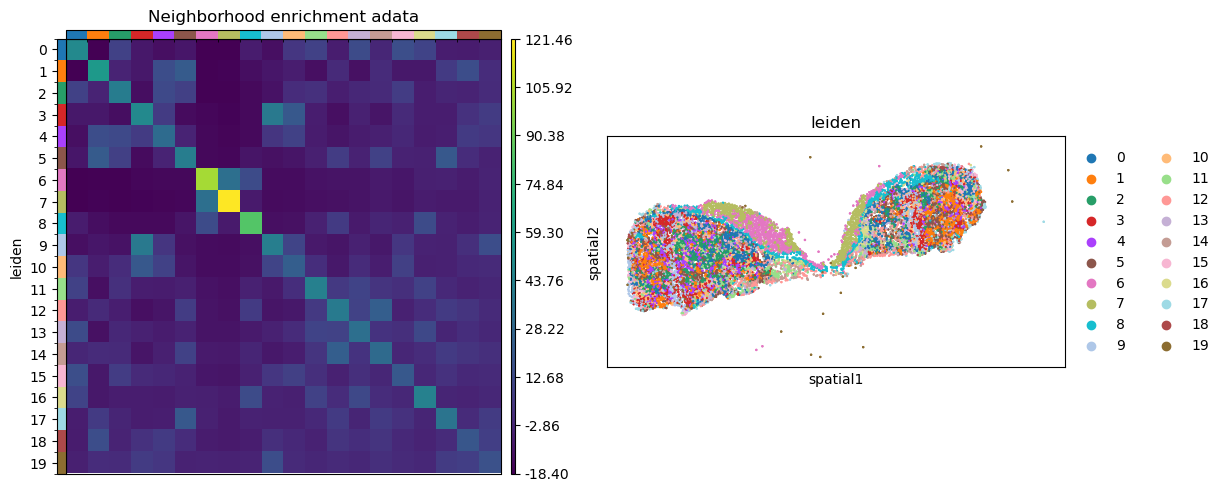

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata, color="leiden", shape=None, size=2, ax=ax[1])

# Save

In [63]:
adata.write_h5ad(f"pilot_data/region_{region}/region_{region}_adata_processed.h5ad")